<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/GroupViT/Inference_with_GroupViT_for_zero_shot_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference with GroupViT: zero-shot semantic segmentation

You probably know [CLIP](https://huggingface.co/docs/transformers/model_doc/clip), the famous work by OpenAI that was trained on 400 million (image, text) pairs in a contrastive way to match image with text. That way, the model is (among other things) capable of **zero-shot image classification** (which means, classifying images without requiring any label), by simply casting image classification as the task of pairing an image with the appropriate text.

Let me introduce you to a new model, [GroupViT](https://twitter.com/xiaolonw/status/1501239921503129600), which does something very simillar to CLIP, but for the case of **zero-shot semantic segmentation**. Semantic segmentation is the task of labeling every pixel of an image with a certain class (like "sky", "person", etc.). Typically, one trains a model on a labeled dataset (classical supervised learning). But creating labels for semantic segmentation is a very time-consuming task, as humans need to annotate each pixel of an image with a certain class.

Enter GroupViT: the model is trained, similar to CLIP, on a lot of (image, text) pairs, and after training, the model is capable of recognizing groups of certain semantic categories in an image, just by linking the name of the semantic category to the image.

Paper: https://arxiv.org/abs/2202.11094

🤗 Docs: https://huggingface.co/docs/transformers/main/en/model_doc/groupvit

Let's illustrate this with an example!

## Set-up environment

First, let's install 🤗 HuggingFace Transformers and HuggingFace Datasets.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

Cloning into 'transformers'...
remote: Enumerating objects: 117862, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 117862 (delta 73), reused 87 (delta 27), pack-reused 117686
Receiving objects: 100% (117862/117862), 106.38 MiB | 14.54 MiB/s, done.
Resolving deltas: 100% (86506/86506), done.
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
!pip install -q datasets

## Load model and processor

Here we load the model as well as the processor from the [HuggingFace Hub](https://huggingface.co/). Note that NVIDIA has released several checkpoints, all of which can be found [here](https://huggingface.co/models?other=groupvit). Be sure to play around with them!

We'll also load the processor, which can be used to prepare images + texts for the model. 

We move the model to GPU if it's available.

In [3]:
from transformers import AutoProcessor, GroupViTModel
import torch

# load model + processor
model_name = "nvidia/groupvit-gcc-yfcc"
processor = AutoProcessor.from_pretrained(model_name)
model = GroupViTModel.from_pretrained(model_name)

# move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading:   0%|          | 0.00/4.53k [00:00<?, ?B/s]

GroupViTModel(
  (text_model): GroupViTTextTransformer(
    (embeddings): GroupViTTextEmbeddings(
      (token_embedding): Embedding(49408, 256)
      (position_embedding): Embedding(77, 256)
    )
    (encoder): GroupViTTextEncoder(
      (layers): ModuleList(
        (0): GroupViTEncoderLayer(
          (self_attn): GroupViTAttention(
            (k_proj): Linear(in_features=256, out_features=256, bias=True)
            (v_proj): Linear(in_features=256, out_features=256, bias=True)
            (q_proj): Linear(in_features=256, out_features=256, bias=True)
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (mlp): GroupViTMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=256, out_features=1024, bias=True)
            (fc2): Linear(in_features=1024, out_features=256, bias=True)
          )
          (layer_norm2): Laye

## Prepare image

Here, we load an image from the ADE20k dataset (actually called the [MIT Scene Parsing Benchmark](http://sceneparsing.csail.mit.edu/)), an important benchmark for semantic segmentation. We also load its corresponding ground truth segmentation map.

No config specified, defaulting to: fixtures_ade20k/image
Reusing dataset fixtures_ade20k (/root/.cache/huggingface/datasets/hf-internal-testing___fixtures_ade20k/image/1.9.0/dbb69c3ff2da9a2dcc2de41e8d7ab6543402914292e3d29a4f9701bef817e7db)


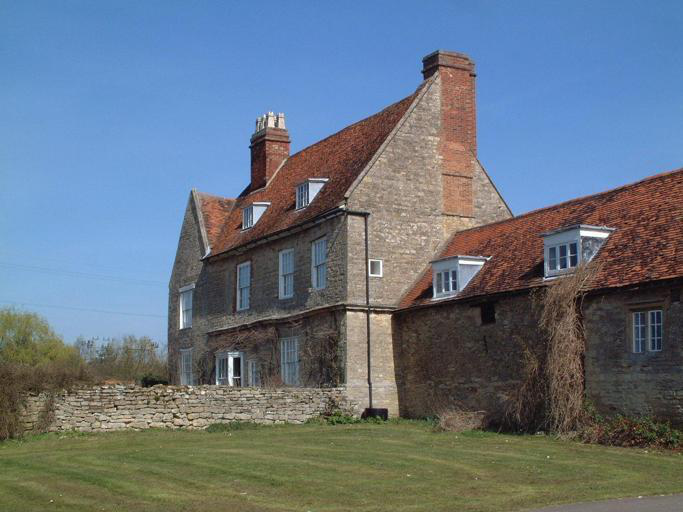

In [4]:
from datasets import load_dataset
from PIL import Image

# load image + ground truth map
ds = load_dataset("hf-internal-testing/fixtures_ade20k", split="test")
image = Image.open(ds[0]["file"])
display(image)
segmentation_map = Image.open(ds[1]["file"])
image = image.resize((224, 224))

GroupViT learns to match semantic categories to pixels.

First, we'll collect the 150 ADE20k classes for which the model can find a match with the pixels of the image.

In [5]:
def ade_class():
    """ADE20K classes names."""
    return [
         'wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road', 'bed ',
        'windowpane', 'grass', 'cabinet', 'sidewalk', 'person', 'earth',
        'door', 'table', 'mountain', 'plant', 'curtain', 'chair', 'car',
        'water', 'painting', 'sofa', 'shelf', 'house', 'sea', 'mirror', 'rug',
        'field', 'armchair', 'seat', 'fence', 'desk', 'rock', 'wardrobe',
        'lamp', 'bathtub', 'railing', 'cushion', 'base', 'box', 'column',
        'signboard', 'chest of drawers', 'counter', 'sand', 'sink',
        'skyscraper', 'fireplace', 'refrigerator', 'grandstand', 'path',
        'stairs', 'runway', 'case', 'pool table', 'pillow', 'screen door',
        'stairway', 'river', 'bridge', 'bookcase', 'blind', 'coffee table',
        'toilet', 'flower', 'book', 'hill', 'bench', 'countertop', 'stove',
        'palm', 'kitchen island', 'computer', 'swivel chair', 'boat', 'bar',
        'arcade machine', 'hovel', 'bus', 'towel', 'light', 'truck', 'tower',
        'chandelier', 'awning', 'streetlight', 'booth', 'television receiver',
        'airplane', 'dirt track', 'apparel', 'pole', 'land', 'bannister',
        'escalator', 'ottoman', 'bottle', 'buffet', 'poster', 'stage', 'van',
        'ship', 'fountain', 'conveyer belt', 'canopy', 'washer', 'plaything',
        'swimming pool', 'stool', 'barrel', 'basket', 'waterfall', 'tent',
        'bag', 'minibike', 'cradle', 'oven', 'ball', 'food', 'step', 'tank',
        'trade name', 'microwave', 'pot', 'animal', 'bicycle', 'lake',
        'dishwasher', 'screen', 'blanket', 'sculpture', 'hood', 'sconce',
        'vase', 'traffic light', 'tray', 'ashcan', 'fan', 'pier', 'crt screen',
        'plate', 'monitor', 'bulletin board', 'shower', 'radiator', 'glass',
        'clock', 'flag'
    ]

Next, we prepare the image + texts for the model. We basically create 150 image-text pairs for the model.

In [6]:
inputs = processor(
    text=[f"a photo of a {word}" for word in ade_class()],
    images=image,
    return_tensors="pt",
    padding=True,
).to(device)

In [11]:
for k,v in inputs.items():
  print(k,v.shape)

input_ids torch.Size([150, 9])
attention_mask torch.Size([150, 9])
pixel_values torch.Size([1, 3, 224, 224])


## Forward pass

Next, let's forward the `pixel values` and the `input_ids` through the model in order to obtain the logits.

In [7]:
outputs = model(**inputs, output_segmentation=True)
logits = outputs.segmentation_logits

## Visualize

Finally, let's visualize the segmentation map as predicted by the model. Semantic segmentation datasets typically define what is called a "palette", that defines the RGB values to use for each of the classes. 

The ADE20k dataset consists of 150 classes, so the list below has 150 elements.

In [8]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

The model outputs logits of shape `(batch_size, num_labels, height/4, width/4)`.  We first rescale the logits to match the original size of the image using bilinear interpolation. Next, we perform an argmax on the class dimension, and we create a color map which we draw over the image.

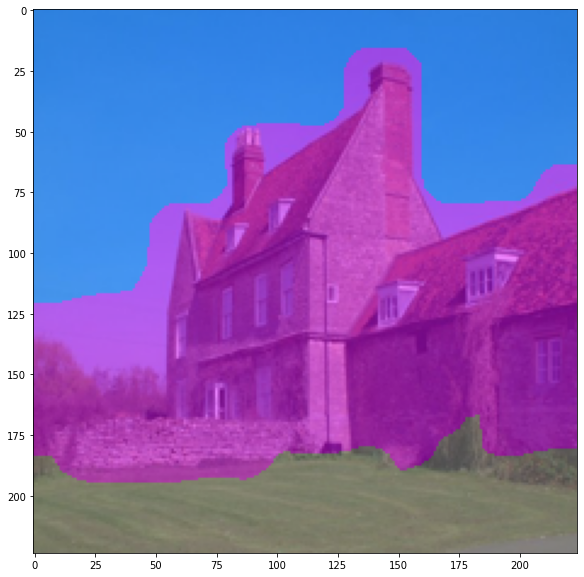

In [9]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
logits = nn.functional.interpolate(logits.detach().cpu(),
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

The model is capable of doing this without ever being trained on human annotated semantic datasets.

Amazing, isn't it? It shows the potential of what language can do to improve computer vision models.